In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.insert(0, module_path)

In [2]:
import ccd
from test.shared import read_data

In [3]:
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np
%matplotlib inline

In [6]:
data = read_data('../test/resources/test_3657_3610_observations.csv')
dates, blues, greens, reds, nirs, swir1s, swir2s, thermals, qas = data
results = ccd.detect(dates, blues, greens, reds, nirs, swir1s, swir2s, thermals, qas, duplicate_dates=True)

2017-01-17 13:46:26 procedures::fit_procedure        - [62 ]Procedure selected: standard_procedure
2017-01-17 13:46:26 procedures::standard_procedure   - [216]Build change models – dates: 443, obs: (7, 443), meow_size: 12, peek_size: 6
2017-01-17 13:46:26 procedures::standard_procedure   - [241]Processing mask initial count: 295
2017-01-17 13:46:26 procedures::standard_procedure   - [257]Variogram values: [  98.   129.   148.5  237.   167.   142.5  395. ]
2017-01-17 13:46:26 procedures::standard_procedure   - [262]Initialize for change model #: 1
2017-01-17 13:46:26 change    ::initialize           - [344]Initial slice(0, 12, None)
2017-01-17 13:46:26 change    ::find_time_index      - [162]Sufficient time from times[0..12] (day #723883 to #724867)
2017-01-17 13:46:26 change    ::initialize           - [354]Checking window: slice(0, 12, None)
2017-01-17 13:46:26 change    ::initialize           - [362]Number of Tmask outliers found: 0
2017-01-17 13:46:26 change    ::initialize         

Start Date: 1982-12-04 00:00:00
End Date: 2014-11-02 00:00:00

Result: 0
Start Date: 1984-04-21 00:00:00
End Date: 1988-04-16 00:00:00
Break Date: 1988-05-18 00:00:00
Observations: 25

Result: 1
Start Date: 1988-05-18 00:00:00
End Date: 1993-05-16 00:00:00
Break Date: 1993-06-01 00:00:00
Observations: 38

Result: 2
Start Date: 1994-04-17 00:00:00
End Date: 2003-06-13 00:00:00
Break Date: 2003-06-29 00:00:00
Observations: 71

Result: 3
Start Date: 2003-06-29 00:00:00
End Date: 2010-10-22 00:00:00
Break Date: 2011-04-24 00:00:00
Observations: 79

Result: 4
Start Date: 2011-04-24 00:00:00
End Date: 2014-07-21 00:00:00
Break Date: 2014-08-30 00:00:00
Observations: 40



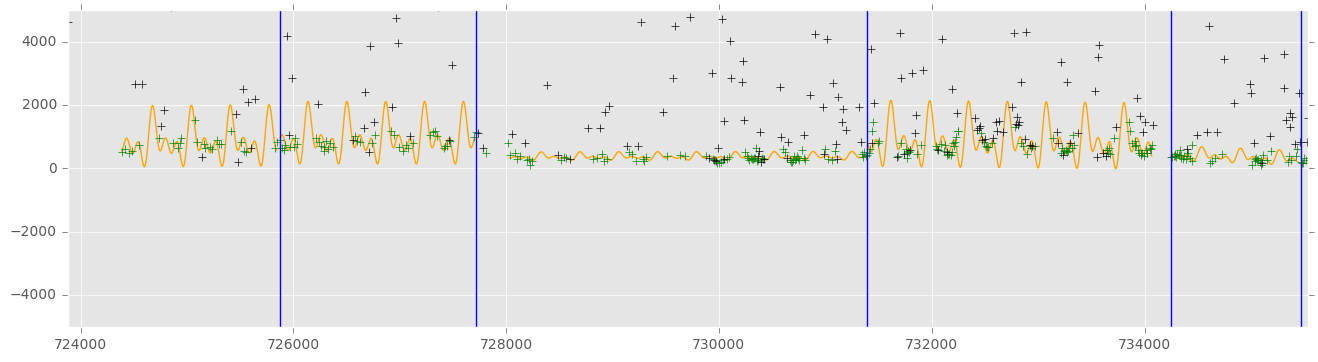

In [5]:
mask = results['processing_mask']
print('Start Date: {0}\nEnd Date: {1}\n'.format(datetime.fromordinal(dates[0]),
                                                datetime.fromordinal(dates[-1])))

predicted_values = []
prediction_dates = []
break_dates = []

for num, result in enumerate(results['change_models']):
    print('Result: {}'.format(num))
    print('Start Date: {}'.format(datetime.fromordinal(result.start_day)))
    print('End Date: {}'.format(datetime.fromordinal(result.end_day)))
    print('Break Date: {}'.format(datetime.fromordinal(result.break_day)))
    print('Observations: {}\n'.format(result.observation_count))
    
    days = np.arange(result.start_day, result.end_day + 1)
    prediction_dates.append(days)
    break_dates.append(result.break_day)
    
    intercept = result.green.intercept
    coef = result.green.coefficients
    
    predicted_values.append(intercept + coef[0] * days +
                            coef[1]*np.cos(days*1*2*np.pi/365.25) + coef[1]*np.sin(days*1*2*np.pi/365.25) +
                            coef[1]*np.cos(days*2*2*np.pi/365.25) + coef[1]*np.sin(days*2*2*np.pi/365.25) +
                            coef[1]*np.cos(days*3*2*np.pi/365.25) + coef[1]*np.sin(days*3*2*np.pi/365.25))
    
plt.style.use('ggplot')

fg = plt.figure(figsize=(16,9), dpi=300)
a1 = fg.add_subplot(2, 1, 1, xlim=(min(dates), max(dates)), ylim=(-5000, 5000))

# Predicted curves
for _preddate, _predvalue in zip(prediction_dates, predicted_values):
    a1.plot(_preddate, _predvalue, 'orange', linewidth=1)

a1.plot(dates[mask], greens[mask], 'g+') # Observed values
a1.plot(dates[~mask], greens[~mask], 'k+') # Observed values masked out
for b in break_dates: a1.axvline(b)